<p>UC00183_“Data-Driven_Climate_Resilience_for_Melbourne_Integrating_Sensors_Canopy_Coverage_and_Population_Growth”<p>
<p><strong>Authored by:</strong> Harshith Maddila</p>
<p><strong>Duration:</strong> 120 mins<br>
<strong>Level:</strong> Intermediate<br>
<strong>Pre-requisite Skills:</strong> Python, Pandas, GeoPandas, Data Visualisation</p>


<h2>Scenario</h2>
<p>
Melbourne faces increasing environmental stress due to climate change, urban heat islands, and rapid population growth.
Tree canopies are known to help mitigate extreme temperatures and air pollution, but their impact across different
zones in Melbourne is not evenly distributed. This project integrates real-time microclimate sensor data,
urban greening spatial datasets (tree canopy coverage), and long-term population growth forecasts to analyse and
visualise climate vulnerability. It aims to guide city planners in prioritising areas for green infrastructure
interventions and sustainable development.
</p>


<h2>User Story</h2>
<p>
As a city planner or environmental analyst, I want to identify areas in Melbourne that are prone to heat stress
and poor air quality, especially in high-growth zones, so that I can prioritise green infrastructure
initiatives and recommend tree planting or cooling interventions in the most vulnerable regions.
</p>

<h2>What This Use Case Will Teach You</h2>
<ul>
  <li>How to preprocess and integrate spatial and temporal environmental datasets</li>
  <li>Feature engineering from microclimate and greening data (e.g., canopy density, temperature trends)</li>
  <li>Using clustering and regression models to detect pollution and temperature hotspots</li>
  <li>Creating spatial vulnerability maps to support data-driven urban planning</li>
  <li>Forecasting the impact of population growth on urban heat exposure</li>
</ul>


<h2>Introduction</h2>
<p>
Urban sustainability in cities like Melbourne is challenged by rising temperatures, uneven green cover,
and population pressures. This project analyses how urban greening (tree canopies) contributes to
cooling and air quality improvement, using real sensor readings and spatial data. The analysis not only
detects current vulnerable zones but also overlays future population projections to guide long-term resilience strategies.
</p>


<h2>Datasets</h2>
<p>Three key datasets are used in this project:</p>
<ul>
  <li><strong>Microclimate Sensor Dataset</strong>
    <ul>
      <li>Includes temperature, humidity, wind, PM2.5, PM10, and location with timestamps</li>
      <li>Used for time-series analysis and heat/pollution hotspot detection</li>
    </ul>
  </li>
  <li><strong>Tree Canopy Dataset (2021)</strong>
    <ul>
      <li>GeoJSON-style spatial polygon data representing canopy-covered areas</li>
      <li>Used to calculate canopy density and proximity to sensor points</li>
    </ul>
  </li>
  <li><strong>Population Forecasts Dataset (2020–2040)</strong>
    <ul>
      <li>Population projections by age, gender, and Melbourne suburbs</li>
      <li>Used to identify future high-growth areas potentially at climate risk</li>
    </ul>
  </li>
</ul>





<h2>Project Goals</h2>
<p>
This project aims to provide a data-driven foundation for urban sustainability and environmental planning by addressing the following goals:
</p>

<ol>
  <li><strong>Assess the Impact of Tree Canopies:</strong> 
    Quantify how tree canopy coverage influences temperature and air quality (PM2.5, PM10) using spatial joins and temporal analysis.
  </li>
  <li><strong>Identify Vulnerable Zones:</strong> 
    Detect heat and pollution hotspots through clustering, and evaluate their exposure relative to tree cover and forecasted population growth.
  </li>
  <li><strong>Forecast Growth-Driven Climate Risk:</strong> 
    Overlay population projections to highlight future high-risk areas where urban heat stress may intensify without intervention.
  </li>
  <li><strong>Create a Heat Vulnerability Index (HVI):</strong> 
    Develop a composite index based on temperature, air quality, tree cover, and demographic exposure to guide prioritisation.
  </li>
  <li><strong>Support Greening Strategy Decisions:</strong> 
    Generate actionable insights and visualisations for urban planners to allocate greening efforts effectively and equitably.
  </li>
</ol>


<h2>Importing Packages</h2>

In [152]:
import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

<h2>Importing Datasets</h2>

In [155]:
def download_dataset(api_key, dataset_id, base_url='https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'):
    format = 'csv'
    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1, 
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': api_key
    }

    with requests.get(url, params=params, stream=True) as response:
        if response.status_code == 200:
            total_size = int(response.headers.get('content-length', 0))
            chunk_size = 1024  
            progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc=f"Downloading {dataset_id}")

            content = bytearray()
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:  
                    content.extend(chunk)
                    progress_bar.update(len(chunk))

            progress_bar.close()
            data = pd.read_csv(StringIO(content.decode('utf-8')), delimiter=';')
            return data
        else:
            print(f'Request failed with status code {response.status_code}')
            return None

# Dataset IDs
dataset_ids = ['microclimate-sensors-data','tree-canopies-2021-urban-forest','city-of-melbourne-population-forecasts-by-small-area-2020-2040']

# Initialize dictionary to hold the datasets
datasets = {}

# Download each dataset with a progress bar
for dataset_id in dataset_ids:
    datasets[dataset_id] = download_dataset('', dataset_id)
    if datasets[dataset_id] is not None:
        print(f"{dataset_id} downloaded successfully.")

# Convert datasets to DataFrames
climate_sensor_df = datasets['microclimate-sensors-data']#dataset 1
canopy_df = datasets['tree-canopies-2021-urban-forest']#dataset 2
population_df= datasets['city-of-melbourne-population-forecasts-by-small-area-2020-2040'] #dataset 3

microclimate-sensors-data downloaded successfully.


tree-canopies-2021-urban-forest downloaded successfully.


city-of-melbourne-population-forecasts-by-small-area-2020-2040 downloaded successfully.


In [162]:
# Displaying first 5 rows of the climate-sensor dataset
climate_sensor_df.head()


,device_id,received_at,sensorlocation,latlong,minimumwinddirection,averagewinddirection,maximumwinddirection,minimumwindspeed,averagewindspeed,gustwindspeed,airtemperature,relativehumidity,atmosphericpressure,pm25,pm10,noise
0,ICTMicroclimate-06,2025-07-28T15:41:16+00:00,Tram Stop 7B - Melbourne Tennis Centre Precinc...,"-37.8194993, 144.9787211",0.0,278.0,359.0,0.0,1.0,3.8,9.6,78.2,1012.3,1.0,1.0,54.6
1,ICTMicroclimate-10,2025-07-28T16:21:11+00:00,1 Treasury Place,"-37.8128595, 144.9745395",262.0,310.0,353.0,0.1,0.9,1.1,8.5,93.8,1008.8,2.0,4.0,77.0
2,ICTMicroclimate-11,2025-07-28T16:05:10+00:00,1 Treasury Place,"-37.812888, 144.9750857",0.0,352.0,359.0,0.1,1.8,4.4,9.3,79.5,1008.3,0.0,1.0,63.6
3,ICTMicroclimate-10,2025-08-02T21:29:31+00:00,1 Treasury Place,"-37.8128595, 144.9745395",309.0,328.0,347.0,0.4,1.0,1.6,3.7,99.7,1021.9,37.0,42.0,73.0
4,ICTMicroclimate-11,2025-08-02T21:58:33+00:00,1 Treasury Place,"-37.812888, 144.9750857",0.0,348.0,357.0,0.0,0.7,2.5,4.9,87.2,1021.3,34.0,36.0,52.0


In [164]:
#Summary statistics for numeric columns in the climate dataset.
climate_sensor_df.describe()

,minimumwinddirection,averagewinddirection,maximumwinddirection,minimumwindspeed,averagewindspeed,gustwindspeed,airtemperature,relativehumidity,atmosphericpressure,pm25,pm10,noise
count,375330.000000,416931.000000,375172.000000,375172.000000,416931.000000,375172.000000,416931.000000,416931.000000,416931.000000,397811.000000,397811.000000,397811.000000
mean,20.684992,167.243079,304.924483,4.518655,1.057958,3.422389,16.058731,66.954858,1002.862015,19.182016,8.087994,66.470931
std,58.277341,125.946438,90.587307,37.420277,0.980863,2.598831,6.052302,18.186087,105.077306,114.612208,12.342138,12.922318
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.800000,4.000000,20.900000,0.000000,0.000000,0.000000
25%,0.000000,43.000000,312.000000,0.000000,0.400000,1.500000,11.800000,55.700000,1008.800000,1.000000,3.000000,59.000000
50%,0.000000,159.000000,353.000000,0.000000,0.800000,2.800000,15.400000,68.700000,1014.600000,3.000000,5.000000,68.300000
75%,0.000000,304.000000,358.000000,0.100000,1.500000,4.800000,19.500000,79.900000,1020.100000,7.000000,9.000000,72.400000
max,359.000000,359.000000,360.000000,359.000000,11.100000,52.500000,40.800000,99.800003,1042.900000,1030.700000,308.000000,131.100000


In [165]:
#  Quick summary of the DataFrame structure
climate_sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417442 entries, 0 to 417441
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   device_id             417442 non-null  object 
 1   received_at           417442 non-null  object 
 2   sensorlocation        411299 non-null  object 
 3   latlong               405959 non-null  object 
 4   minimumwinddirection  375330 non-null  float64
 5   averagewinddirection  416931 non-null  float64
 6   maximumwinddirection  375172 non-null  float64
 7   minimumwindspeed      375172 non-null  float64
 8   averagewindspeed      416931 non-null  float64
 9   gustwindspeed         375172 non-null  float64
 10  airtemperature        416931 non-null  float64
 11  relativehumidity      416931 non-null  float64
 12  atmosphericpressure   416931 non-null  float64
 13  pm25                  397811 non-null  float64
 14  pm10                  397811 non-null  float64
 15  

In [168]:
# Displaying first 5 rows of tree canopy dataset
canopy_df.head()

,geo_point_2d,geo_shape
0,"-37.77506304683423, 144.93898465421296","{""coordinates"": [[[[144.9389624164712, -37.775..."
1,"-37.775132956993566, 144.93979253397976","{""coordinates"": [[[[144.93978541786475, -37.77..."
2,"-37.775360479960504, 144.94145114868167","{""coordinates"": [[[[144.941452857118, -37.7753..."
3,"-37.77547666272367, 144.9397185484928","{""coordinates"": [[[[144.93971571805423, -37.77..."
4,"-37.77536268488935, 144.9389680913816","{""coordinates"": [[[[144.93898921469705, -37.77..."


In [170]:
#Summary statistics for numeric columns in the canopy dataset.
canopy_df.describe()

,geo_point_2d,geo_shape
count,57980,57980
unique,57980,57980
top,"-37.77506304683423, 144.93898465421296","{""coordinates"": [[[[144.9389624164712, -37.775..."
freq,1,1


In [172]:
#  Quick summary of the DataFrame structure
canopy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57980 entries, 0 to 57979
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   geo_point_2d  57980 non-null  object
 1   geo_shape     57980 non-null  object
dtypes: object(2)
memory usage: 906.1+ KB


In [174]:
# Displaying first 5 rows of the population-growth dataset
population_df.head()

,geography,year,gender,age,value
0,Carlton,2023,Female,Age 65-69,224
1,Carlton,2023,Female,Age 85+,66
2,Carlton,2024,Female,Age 25-29,2105
3,Carlton,2024,Female,Age 30-34,1174
4,Carlton,2024,Male,Age 25-29,1978


In [176]:
#Summary statistics for numeric columns in the population dataset.
population_df.describe()

,year,value
count,10584.000000,10584.000000
mean,2033.000000,963.766440
std,6.055587,2648.803599
min,2023.000000,0.000000
25%,2028.000000,81.000000
50%,2033.000000,222.000000
75%,2038.000000,667.000000
max,2043.000000,27630.000000


In [178]:
#  Quick summary of the DataFrame structure
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10584 entries, 0 to 10583
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   geography  10584 non-null  object
 1   year       10584 non-null  int64 
 2   gender     10584 non-null  object
 3   age        10584 non-null  object
 4   value      10584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 413.6+ KB


<h2>Data Cleaning</h2>

<h3>Cleaning Climate Sensor Dataset</h3>

In [182]:
# Check missing values before cleaning
print(" Missing values in Climate Sensor (before cleaning):")
print(climate_sensor_df.isnull().sum())

#  Clean data
climate_sensor_df.dropna(subset=["latlong", "airtemperature", "pm25", "pm10"], inplace=True)
# Drop wind-related columns with many nulls
climate_sensor_df.drop(columns=[
    "minimumwinddirection", "maximumwinddirection", "minimumwindspeed",
    "gustwindspeed"
], inplace=True)

climate_sensor_df[["latitude", "longitude"]] = climate_sensor_df["latlong"].str.split(",", expand=True).astype(float)
climate_sensor_df["received_at"] = pd.to_datetime(climate_sensor_df["received_at"], errors="coerce")

# Results after cleaning
print("\n Climate Sensor cleaned:")
print(climate_sensor_df.isnull().sum())
print("Shape:", climate_sensor_df.shape)


 Missing values in Climate Sensor (before cleaning):
device_id                   0
received_at                 0
sensorlocation           6143
latlong                 11483
minimumwinddirection    42112
averagewinddirection      511
maximumwinddirection    42270
minimumwindspeed        42270
averagewindspeed          511
gustwindspeed           42270
airtemperature            511
relativehumidity          511
atmosphericpressure       511
pm25                    19631
pm10                    19631
noise                   19631
dtype: int64

 Climate Sensor cleaned:
device_id               0
received_at             0
sensorlocation          0
latlong                 0
averagewinddirection    0
averagewindspeed        0
airtemperature          0
relativehumidity        0
atmosphericpressure     0
pm25                    0
pm10                    0
noise                   0
latitude                0
longitude               0
dtype: int64
Shape: (386680, 14)


<p>
The raw datasets were inspected for missing values, inconsistent formats, and irrelevant attributes prior to analysis. 
The <strong>climate sensor dataset</strong> required extensive cleaning due to the presence of missing values in critical columns such as 
<em>air temperature</em>, <em>PM2.5</em>, and <em>PM10</em>, as well as formatting issues in the combined <code>latlong</code> field. 
These columns were used to filter out incomplete rows, and the <code>latlong</code> field was split into separate 
<code>latitude</code> and <code>longitude</code> features for spatial analysis. Timestamps were also converted into datetime format 
to support time-series operations.
</p>

<h3>Cleaning Canopy Dataset</h3>

In [ ]:
# Check missing values before cleaning
print(" Missing values in Tree Canopy (before cleaning):")
print(canopy_df.isnull().sum())
# Clean and transform Tree Canopy dataset
canopy_df[["latitude", "longitude"]] = canopy_df["geo_point_2d"].str.split(",", expand=True).astype(float)

# Confirm transformation
print("\n Tree Canopy cleaned and coordinates extracted:")
print(canopy_df.head())
print("Shape:", canopy_df.shape)



<p>
In the <strong>tree canopy dataset</strong>, no missing values were identified. The coordinate information was extracted 
from the <code>geo_point_2d</code> field and split into <code>latitude</code> and <code>longitude</code> columns 
to enable mapping and spatial joins with other datasets.
</p>

<h3>Cleaning Population Growth Dataset</h3>

In [192]:
# Check missing values before cleaning
print(" Missing values in Population Forecast (before cleaning):")
print(population_df.isnull().sum())

# Clean data
population_df.columns = population_df.columns.str.replace("\ufeff", "").str.strip().str.replace(" ", "_")
population_df.dropna(subset=["geography", "year", "value"], inplace=True)
population_df["year"] = pd.to_numeric(population_df["year"], errors="coerce")
population_df["value"] = pd.to_numeric(population_df["value"], errors="coerce")

# Results after cleaning
print("\n Population Forecast cleaned:")
print(population_df.isnull().sum())
print("Shape:", population_df.shape)


 Missing values in Population Forecast (before cleaning):
geography    0
year         0
gender       0
age          0
value        0
dtype: int64

 Population Forecast cleaned:
geography    0
year         0
gender       0
age          0
value        0
dtype: int64
Shape: (10584, 5)


<p>
The <strong>population forecast dataset</strong> was cleaned by removing rows with null values in the <code>Geography</code>, 
<code>Year</code>, or <code>Value</code> columns. Data types were appropriately converted to numeric and datetime formats 
to facilitate forecasting and grouping operations.
</p>


<h2>Exploratory Data Analysis (EDA)</h2>
<p>
To gain insights into microclimate conditions across Melbourne, several exploratory plots were created using the climate sensor dataset.
The focus was on analysing temperature, PM2.5, and PM10 levels using distributional, temporal, and correlation-based visualisations.
</p>

<h3>1. Distribution of Climate Variables</h3>
<p>
The distribution plots for <strong>air temperature</strong>, <strong>PM2.5</strong>, and <strong>PM10</strong> revealed key patterns in the dataset.
Air temperature values mostly ranged between 10°C and 25°C with a clear bell-shaped curve centered around ~15°C, indicating a normal distribution.
On the other hand, both PM2.5 and PM10 distributions were highly right-skewed, with the majority of values concentrated below 20 µg/m³, 
but a noticeable number of outliers reaching as high as 300 µg/m³. These extreme values suggest short bursts of high pollution likely due to specific events.
</p>

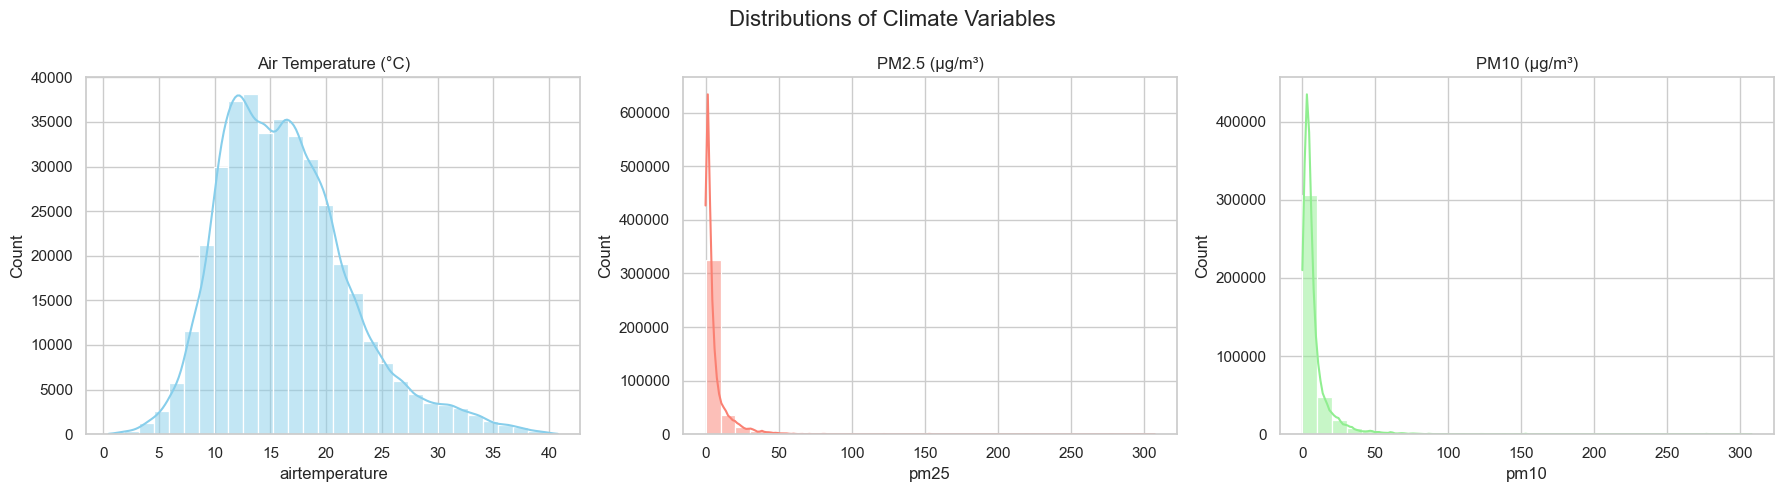

In [196]:
sns.set(style="whitegrid")

# =====================
# Distribution Plots
# =====================
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(climate_sensor_df["airtemperature"], kde=True, bins=30, ax=axs[0], color="skyblue")
axs[0].set_title("Air Temperature (°C)")

sns.histplot(climate_sensor_df["pm25"], kde=True, bins=30, ax=axs[1], color="salmon")
axs[1].set_title("PM2.5 (µg/m³)")

sns.histplot(climate_sensor_df["pm10"], kde=True, bins=30, ax=axs[2], color="lightgreen")
axs[2].set_title("PM10 (µg/m³)")

plt.suptitle("Distributions of Climate Variables", fontsize=16)
plt.tight_layout()
plt.show()


<h3>2. Daily Average Trends Over Time</h3>
<p>
Time series plots showed the fluctuation of daily average temperature and particulate matter over the last year. 
Air temperature followed a seasonal trend, peaking in summer months and declining in winter. 
Meanwhile, PM2.5 and PM10 displayed irregular spikes, with some dates showing sharp increases above 40 µg/m³ — potentially aligned with construction activity, traffic, or dry conditions.
These patterns are critical for identifying temporal pollution risks.
</p>

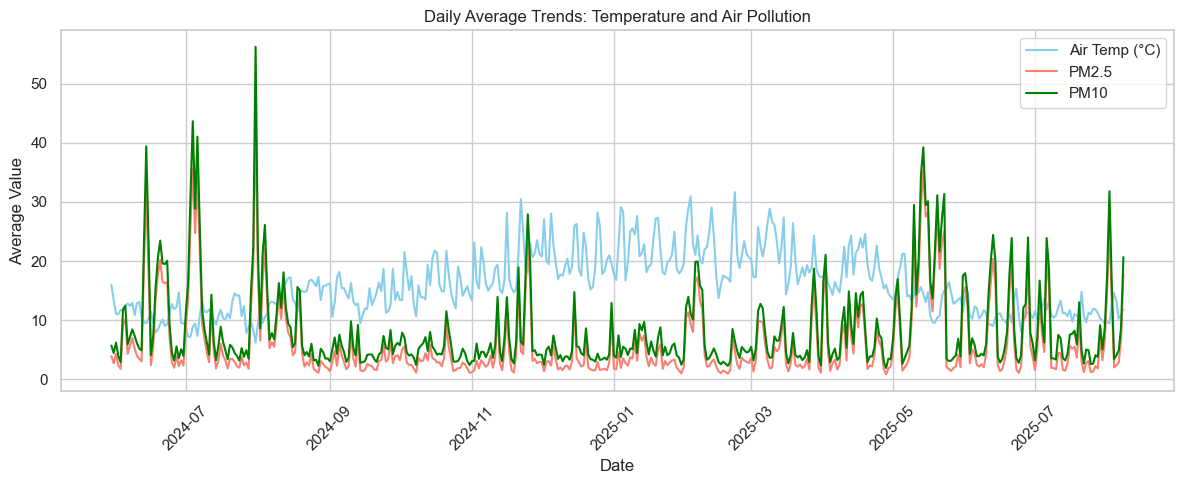

In [198]:
# Extract date
climate_sensor_df["date"] = climate_sensor_df["received_at"].dt.date

# Group by day
daily_avg = climate_sensor_df.groupby("date")[["airtemperature", "pm25", "pm10"]].mean().reset_index()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=daily_avg, x="date", y="airtemperature", label="Air Temp (°C)", color="skyblue")
sns.lineplot(data=daily_avg, x="date", y="pm25", label="PM2.5", color="salmon")
sns.lineplot(data=daily_avg, x="date", y="pm10", label="PM10", color="green")

plt.title("Daily Average Trends: Temperature and Air Pollution")
plt.xlabel("Date")
plt.ylabel("Average Value")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


<h3>3. Outlier Detection via Boxplots</h3>
<p>
Boxplots confirmed the presence of several high-value outliers, especially in PM2.5 and PM10 readings.
Most of the particulate data clustered below 25 µg/m³, while many outliers extended well above 100 µg/m³.
Although air temperature exhibited fewer outliers, its range still showed some extreme values approaching 40°C, which are relevant for identifying heat stress zones.
</p>

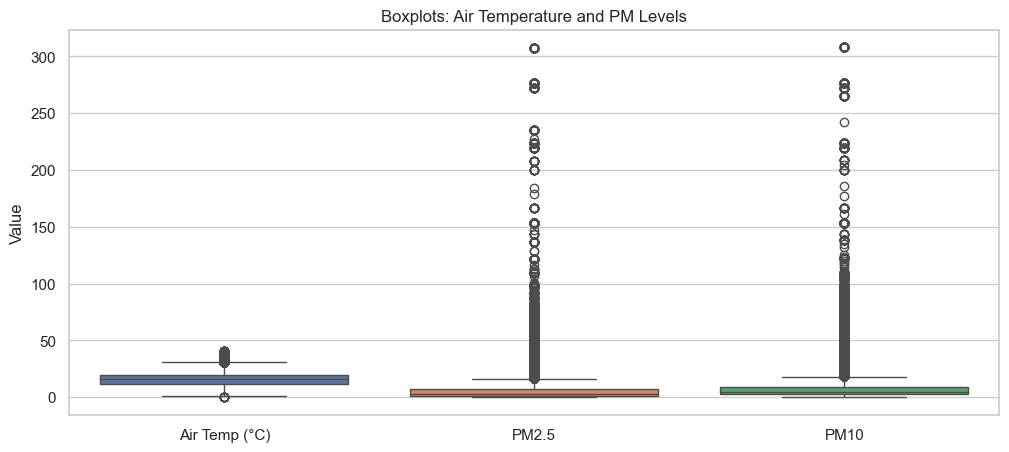

In [200]:
# Boxplots for AirTemperature, PM2.5, PM10
plt.figure(figsize=(12, 5))
sns.boxplot(data=climate_sensor_df[["airtemperature", "pm25", "pm10"]])
plt.title("Boxplots: Air Temperature and PM Levels")
plt.ylabel("Value")
plt.xticks([0, 1, 2], ["Air Temp (°C)", "PM2.5", "PM10"])
plt.show()


<h3>4. Correlation Between Environmental Factors</h3>
<p>
A heatmap of Pearson correlation coefficients revealed a very strong positive correlation (0.99) between PM2.5 and PM10, as expected due to their similar particulate nature.
Air temperature showed a moderate inverse correlation with relative humidity (-0.66), indicating typical atmospheric behavior.
Noise and pollution levels had minimal correlation, suggesting independent sources or measurement conditions.
</p>

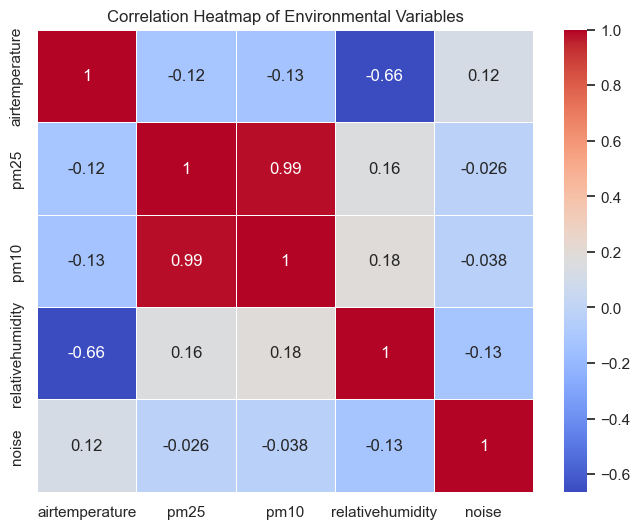

In [202]:
# Correlation matrix
plt.figure(figsize=(8, 6))
corr = climate_sensor_df[["airtemperature", "pm25", "pm10", "relativehumidity", "noise"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Environmental Variables")
plt.show()


<h3>5. Hourly Variation in Microclimate Conditions</h3>
<p>
Hourly average trends showed that air temperature followed a natural daytime pattern, peaking around midday and dropping overnight.
Interestingly, PM2.5 and PM10 were highest during early morning and evening hours, possibly due to traffic congestion, industrial activity, or stagnant air flow.
This highlights potential windows where exposure to poor air quality is more likely and can inform time-sensitive mitigation strategies.
</p>

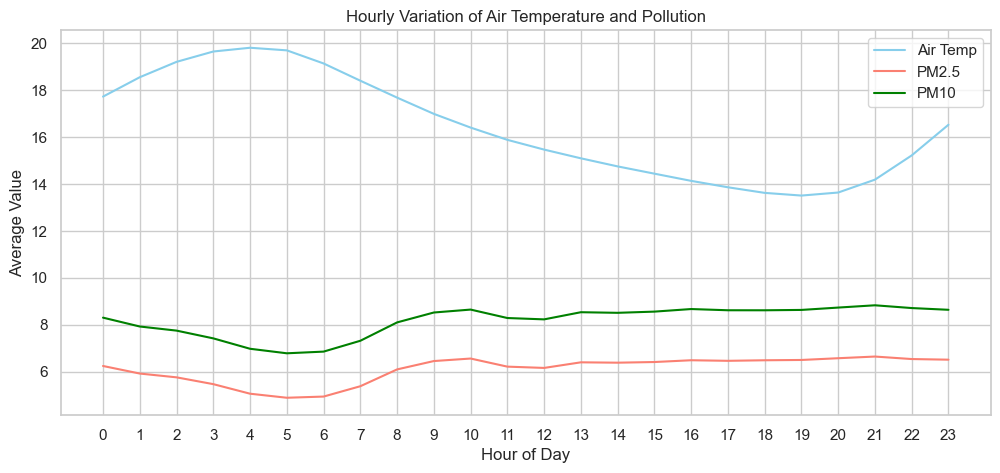

In [204]:
# Extract hour
climate_sensor_df["hour"] = climate_sensor_df["received_at"].dt.hour

# Group by hour
hourly_avg = climate_sensor_df.groupby("hour")[["airtemperature", "pm25", "pm10"]].mean().reset_index()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=hourly_avg, x="hour", y="airtemperature", label="Air Temp", color="skyblue")
sns.lineplot(data=hourly_avg, x="hour", y="pm25", label="PM2.5", color="salmon")
sns.lineplot(data=hourly_avg, x="hour", y="pm10", label="PM10", color="green")
plt.title("Hourly Variation of Air Temperature and Pollution")
plt.xlabel("Hour of Day")
plt.ylabel("Average Value")
plt.legend()
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()
